### Caso práctico ###

1) Datos del problema
- Alternativas: *A, B, C*
- Criterios (mezcla max/min), pesos
  - $g_1$: Beneficio (Max), $w_1$ = 0.4
  - $g_2$: Costo (Min),     $w_2$ = 0.35
  - $g_3$: Latencia (Min),  $w_3$ = 0.25


In [1]:
# Importar las librerías necesarias
import numpy as np

# =========================
# 1. Datos del problema
# =========================
# Tabla de desempeño de las alternativas (A, B, C) para los criterios (g1, g2, g3)
matrix = np.array([
    [80, 50, 120],   # A
    [75, 40, 150],   # B
    [85, 55, 110]    # C
])

# Nombres de las alternativas y criterios
alts = ["A", "B", "C"]
crits = ["g1", "g2", "g3"]

# =========================

# Pesos de los criterios (deben sumar 1)
# =========================
weights = np.array([0.4, 0.35, 0.25])
# =========================
# Tipos de criterio
# g1 = Beneficio (max)  
# g2 = Costo (min) 
# g3 = Latencia (min) 
# =========================
types = np.array([1, -1, -1])

# =========================
# Umbrales de ELECTRE III
# q = indiferencia
# p = preferencia
# v = veto
# =========================
q = np.array([2, 3, 5])   # Indiferencia
p = np.array([6, 8, 15])     # Preferencia
v = np.array([15, 20, 40])     # Veto

In [2]:
# =========================
# 2) Paso: diferencias d_j(a,b) (positivo => a mejor que b)
#    - MAX: d = g(a) - g(b)
#    - MIN: d = g(b) - g(a)
# =========================
def differences_by_criterion(matrix: np.ndarray, types: np.ndarray) -> np.ndarray:
    """
    Devuelve D con shape (m, n, n):
      D[j, i, k] = d_j(alt_i, alt_k)
    donde d>0 significa "alt_i es mejor que alt_k" en el criterio j.
    """
    n, m = matrix.shape
    D = np.zeros((m, n, n), dtype=float)

    for j in range(m):
        g = matrix[:, j]  # valores del criterio j para cada alternativa
        if types[j] == 1:     # MAX
            D[j] = g[:, None] - g[None, :]
        else:                 # MIN
            D[j] = g[None, :] - g[:, None]
    return D

d = differences_by_criterion(matrix, types)

# Imprime las matrices d(gj)
for j, name in enumerate(crits):
    print(f"\n--- d({name}) ---")
    print("     " + "  ".join(alts))
    for i, a in enumerate(alts):
        row = "  ".join(f"{d[j,i,k]:6.1f}" for k in range(len(alts)))
        print(f"{a}  {row}")



--- d(g1) ---
     A  B  C
A     0.0     5.0    -5.0
B    -5.0     0.0   -10.0
C     5.0    10.0     0.0

--- d(g2) ---
     A  B  C
A     0.0   -10.0     5.0
B    10.0     0.0    15.0
C    -5.0   -15.0     0.0

--- d(g3) ---
     A  B  C
A     0.0    30.0   -10.0
B   -30.0     0.0   -40.0
C    10.0    40.0     0.0


In [3]:
# =========================
# 3) Paso: concordancia parcial c_j(a,b) (una matriz n×n por criterio)
#    Usando d definido arriba:
#      c = 1              si d >= -q
#      c = 0              si d <= -p
#      c = (d + p)/(p-q)  si -p < d < -q
# =========================
def partial_concordance(D: np.ndarray, q: np.ndarray, p: np.ndarray) -> np.ndarray:
    """
    Devuelve Cj con shape (m, n, n):
      Cj[j,i,k] = c_j(alt_i, alt_k)
    """
    m, n, _ = D.shape
    Cj = np.zeros_like(D)

    for j in range(m):
        dj = D[j]
        qj, pj = q[j], p[j]

        Cj[j] = np.where(
            dj >= -qj, 1.0,
            np.where(dj <= -pj, 0.0, (dj + pj) / (pj - qj))
        )

        # Convención: diagonal = 1 (misma alternativa)
        np.fill_diagonal(Cj[j], 1.0)

    return Cj

Cj = partial_concordance(d, q, p)

# Imprime c(gj)
for j, name in enumerate(crits):
    print(f"\n--- c({name}) (concordancia parcial) ---")
    print("     " + "  ".join(alts))
    for i, a in enumerate(alts):
        row = "  ".join(f"{Cj[j,i,k]:6.3f}" for k in range(len(alts)))
        print(f"{a}  {row}")


--- c(g1) (concordancia parcial) ---
     A  B  C
A   1.000   1.000   0.250
B   0.250   1.000   0.000
C   1.000   1.000   1.000

--- c(g2) (concordancia parcial) ---
     A  B  C
A   1.000   0.000   1.000
B   1.000   1.000   1.000
C   0.600   0.000   1.000

--- c(g3) (concordancia parcial) ---
     A  B  C
A   1.000   1.000   0.500
B   0.000   1.000   0.000
C   1.000   1.000   1.000


In [4]:
# =========================
# 4) Concordancia global C(a,b)
#    C = sum_j w_j * c_j(a,b)
# =========================
C_global = np.tensordot(weights, Cj, axes=(0, 0))  # (n,n)
np.fill_diagonal(C_global, 0.0)  # a veces se pone 0 en diagonal

print("\n--- C (concordancia global) ---")
print("     " + "  ".join(alts))
for i, a in enumerate(alts):
    row = "  ".join(f"{C_global[i,k]:6.3f}" for k in range(len(alts)))
    print(f"{a}  {row}")


--- C (concordancia global) ---
     A  B  C
A   0.000   0.650   0.575
B   0.450   0.000   0.350
C   0.860   0.650   0.000


In [5]:
# =========================
# 5) Discordancia parcial D_j(a,b)
# =========================
def partial_discordance(d, p, v):
    m, n, _ = d.shape
    Dj = np.zeros_like(d)

    for j in range(m):
        dj = d[j]
        pj, vj = p[j], v[j]

        Dj[j] = np.where(
            dj >= -pj, 0.0,
            np.where(dj <= -vj, 1.0, (-pj - dj) / (vj - pj))
        )
        np.fill_diagonal(Dj[j], 0.0)

    return Dj

D_partial = partial_discordance(d, p, v)

# Imprime D(gj)
for j, name in enumerate(crits):
    print(f"\n--- D({name}) (discordancia parcial) ---")
    print("     " + "  ".join(alts))
    for i, a in enumerate(alts):
        row = "  ".join(f"{D_partial[j,i,k]:6.3f}" for k in range(len(alts)))
        print(f"{a}  {row}")


--- D(g1) (discordancia parcial) ---
     A  B  C
A   0.000   0.000   0.000
B   0.000   0.000   0.444
C   0.000   0.000   0.000

--- D(g2) (discordancia parcial) ---
     A  B  C
A   0.000   0.167   0.000
B   0.000   0.000   0.000
C   0.000   0.583   0.000

--- D(g3) (discordancia parcial) ---
     A  B  C
A   0.000   0.000   0.000
B   0.600   0.000   1.000
C   0.000   0.000   0.000


In [6]:
# =========================
# 6) Matriz de credibilidad S(a,b)
# =========================
def credibility_matrix(C, D_partial):
    m, n, _ = D_partial.shape
    S = C.copy()

    for i in range(n):
        for j in range(n):
            if i == j:
                S[i, j] = 0
                continue

            prod = 1.0
            for k in range(m):
                if D_partial[k, i, j] > C[i, j]:
                    prod *= (1 - D_partial[k, i, j]) / (1 - C[i, j])

            S[i, j] = C[i, j] * prod

    return S

S = credibility_matrix(C_global, D_partial)

In [7]:
# =========================
# 7) Impresión ordenada
# =========================
np.set_printoptions(precision=4, suppress=True)

print("\n=== Concordancia global C ===")
print(C_global)

print("\n=== Matriz de credibilidad S ===")
print(S)


=== Concordancia global C ===
[[0.    0.65  0.575]
 [0.45  0.    0.35 ]
 [0.86  0.65  0.   ]]

=== Matriz de credibilidad S ===
[[0.     0.65   0.575 ]
 [0.3273 0.     0.    ]
 [0.86   0.65   0.    ]]


Convertir credibilidades en relación 𝑆 con un umbral 𝜆

In [8]:
# Se define un umbral lamda 

lambda_cut = 0.65

S_lambda = (S >= lambda_cut).astype(int)

print("\nMatriz de relación S_lambda:")
print(S_lambda)



Matriz de relación S_lambda:
[[0 1 0]
 [0 0 0]
 [1 1 0]]


In [9]:
# outdegree e indegree
outdeg = S_lambda.sum(axis=1)
indeg  = S_lambda.sum(axis=0)

for alt, o, i in zip(["A","B","C"], outdeg, indeg):
    print(alt, "out:", o, "in:", i)

score = outdeg - indeg
ranking = [ ["A","B","C"][i] for i in np.argsort(-score) ]
print("Ranking:", ranking)


A out: 1 in: 1
B out: 0 in: 2
C out: 2 in: 0
Ranking: ['C', 'A', 'B']


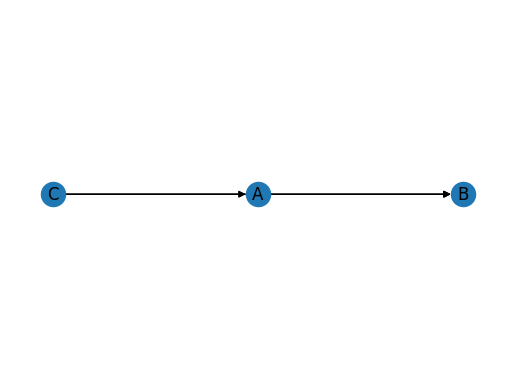

In [10]:
import networkx as nx
import matplotlib.pyplot as plt

# Construir grafo dirigido
G = nx.DiGraph()
G.add_nodes_from(alts)

n = len(alts)
for i in range(n):
    for j in range(n):
        if S_lambda[i, j] == 1:
            G.add_edge(alts[i], alts[j])

# Posiciones (para que se vea ordenado C -> A -> B)
pos = {"C": (0, 0), "A": (1, 0), "B": (2, 0)}

plt.figure()
nx.draw_networkx(G, pos=pos, with_labels=True, arrows=True)
plt.axis("off")
plt.show()


**Solución del ejercicio utilizando la librería de Python pyDecision**

Con el propósito de validar los resultados obtenidos mediante el desarrollo manual del método, se procedió a implementar el algoritmo ELECTRE III utilizando la librería especializada *pyDecision* en Python.

Esta implementación automatiza el cálculo de la concordancia global, la discordancia parcial y la matriz de credibilidad, permitiendo obtener el ordenamiento final de las alternativas bajo el enfoque de sobreclasificación.

In [11]:
# !pip install pyDecision # Uncomment this line for installation
# Se importa el algoritmo de ELECTRE III desde la biblioteca pyDecision
from pyDecision.algorithm import electre_iii

# Datos del problema
matrix = np.array([
    [80, 50, 120],   # A
    [75, 40, 150],   # B
    [85, 55, 110]    # C
], dtype=float)

# Pesos de los criterios (deben sumar 1)
weights = np.array([0.4, 0.35, 0.25], dtype=float)

# Umbrales de ELECTRE III
q = np.array([2, 3, 5], dtype=float)
p = np.array([6, 8, 15], dtype=float)
v = np.array([15, 20, 40], dtype=float)

# convertir a formato beneficio (g2 y g3 son MIN) porque pyDecision asume que todo es beneficio
# g2 y g3 son MIN -> convertir a MAX
matrix_benefit = matrix.copy()
matrix_benefit[:, 1] *= -1  # g2
matrix_benefit[:, 2] *= -1  # g3

# Ejecutar ELECTRE III
result = electre_iii(matrix_benefit, p, q, v, weights, graph=False)

# Mostrar resultado
global_conc, credibility, rank_D, rank_A, rank_M, rank_P = result

print("Concordancia global:\n", global_conc)
print("\nMatriz de credibilidad:\n", credibility)
print("\nRanking D:", rank_D)
print("Ranking A:", rank_A)

Concordancia global:
 [[1.    0.65  0.575]
 [0.45  1.    0.35 ]
 [0.86  0.65  1.   ]]

Matriz de credibilidad:
 [[0.     0.65   0.575 ]
 [0.3273 0.     0.    ]
 [0.86   0.65   0.    ]]

Ranking D: ['a3', 'a1', 'a2']
Ranking A: ['a3', 'a2', 'a1']


In [12]:
global_conc, credibility, rank_D, rank_A, rank_M, rank_P = result

print("Ranking descendente (D):", rank_D)
print("Ranking ascendente (A):", rank_A)
print("Ranking final recomendado:", rank_D)  # si D y A coinciden


Ranking descendente (D): ['a3', 'a1', 'a2']
Ranking ascendente (A): ['a3', 'a2', 'a1']
Ranking final recomendado: ['a3', 'a1', 'a2']


**Interpretación**

A partir de los resultados obtenidos, se interpreta lo siguiente:

- 𝐶 sobreclasifica a 2 (A y B) y nadie lo sobreclasifica → arriba
- 𝐴 sobreclasifica a 1 (B) y es sobreclasificada por C → medio
- 𝐵 no sobreclasifica a nadie y es sobreclasificada por A y C → abajo

Ranking final para este caso:

𝐶≻𝐴≻𝐵

“C es preferida a A y A es preferida a B” (o “C está por encima de A, y A está por encima de B, en
el ranking”).